In [1]:
import numpy as np
import pickle
import os
import sys
import data_process_utils as dpu

In [22]:
def process_annot_line(line):
    line = line.replace("DR","11").replace("DL","12")
    line = line.replace("PR","21").replace("PL","22")    
    line = line.replace("NR","31").replace("NL","32")
    line = line.replace("I","1").replace("Q","2")
    line = line.replace("C","-1").replace("S","-2").replace("M","-3").replace('X', '-100')    
    
    v = line.rstrip().split(',')    
    v = [float(x) for x in v]
    return v

In [ ]:
path = 'C:/ASM/PublicData/eating_steventech/lab'
data = []
for subj in range(7):
    dsubj = []
    asubj = []
    for sess in range(2):        
        if subj==1 and sess==1: continue            
            
        filePathAccel = path + "/0" + str(subj) + "/000" + str(sess) + "/watch_right_000" + str(sess) + ".csv"
        dr = np.genfromtxt(filePathAccel, delimiter=',')
        dr[:, 0] = dr[:, 0]/1e9        
        quat = dr[:, -3:]
        _ , _ , grav = dpu.quat2mat(quat)
        dr = np.concatenate((dr[:, :7], grav), axis=1)
        
        filePathAccel = path + "/0" + str(subj) + "/000" + str(sess) + "/watch_left_000" + str(sess) + ".csv"
        dl = np.genfromtxt(filePathAccel, delimiter=',')
        dl[:, 0] = dl[:, 0]/1e9        
        quat = dl[:, -3:]
        _ , _ , grav = dpu.quat2mat(quat)
        dl = np.concatenate((dl[:, :7], grav), axis=1)

        filePathAnnots = path + "/0" + str(subj) + "/000" + str(sess) + "/annot_events.csv"
        a = open(filePathAnnots).readlines()
        a = [process_annot_line(line) for line in a]
        a = np.array(a)
        
        print(subj, sess, dr.shape, dl.shape, a.shape, end=" | ")        
        dsubj.append({"data_right":dr, "data_left":dl, 'annots':a})
        
    data.append(dsubj)
    
with open('C:/ASM/DevData/eating_steven/data/raw_lab_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
total, bite, sip, repeat = 0, 0, 0, 0
hand_count = [0, 0, 0, 0]
for subj in range(7):
    for sess in range(len(data[subj])):        
        a = np.copy(data[subj][sess]["annots"])        
        acount = len(a)
        
        print(subj, sess, a.shape)
        print('---------------------------')
        
        for c in [1,2, 11, 12, 21, 22]:#[11, 12, 21, 22, 31, 32, 1, 2, -1, -2, -3, -100]:
            x = np.sum(a[:, 2]==c)
            if c==1:
                bite +=x
            elif c==2:
                sip+=x
            print(c," : ", x)
            total+=x
        
        oi = np.arange(acount)
        cond = (a[:, 2]>0) & (a[:, 2]<20)
        a = a[cond]
        oi = oi[cond]
        print(a.shape)
        
        acount = len(a)        
        for i in range(acount-1):
            if a[i, 2]==11 and a[i+1, 2]!=12 and a[i+1,2]!=1 and a[i+1,2]!=2:
                    print("Sequence Problem at ", i, oi[i])
                    
                
            elif a[i, 2]==12 and a[i+1, 2]!=11 and a[i+1,2]!=1 and a[i+1,2]!=2:    
                print("Left Sequence Problem at ", i, oi[i])
                
        i = 0
        hand = 0
        last_was_bite = True
        res = []        
        for i in range(acount):
            if a[i, 2]==11 or a[i, 2]==12:
                if last_was_bite:
                    hand = int(a[i, 2]-10)
                else:
                    print("Both hands at index:", oi[i], ", Time difference: ", a[i, 0]-a[i-1,0])
                    if a[i, 0]-a[i-1,0]>1:
                        print("$$$$$$$$$$$$$$$$$$$$$$ Both hand time problem $$$$$$$$$$$$$$$$$$$$$")
                    hand =3
                
                last_was_bite = False
                repeat_count = 0
                

            elif a[i, 2]==1 or a[i, 2]==2:
                if not last_was_bite:
                    hand_count[hand]+=1
                
                r = [a[i,0], a[i,1], a[i,2], hand, 0]                
                if hand==0:
                    print("***************No hand found**************", i, oi[i])
                elif last_was_bite:
                    repeat_count +=1
                    r[-1] = repeat_count
                    print("***************Bite/Sip repeated**************", i, int(a[i, 0]), "Bite/sip: ", int(a[i, 2]), " hand:", int(hand), r[-1])                    
                    repeat+=1
                    
                res.append(r)                
                last_was_bite = True
        
        print(repeat)
        
print("Total, bie, sip, repeat: ", total, bite, sip, repeat)

In [14]:
print(hand_count)
total = sum(hand_count)
print(total)
print(hand_count[1]/total, hand_count[2]/total, hand_count[3]/total)

[0, 1280, 243, 249]
1772
0.7223476297968398 0.1371331828442438 0.14051918735891647


In [ ]:
for subj in range(7):
    for sess in range(len(data[subj])):
        print(subj, sess)
        d = np.copy(data[subj][sess]["data_right"])
        #ix = 14827
        #df = d[ix+7000, 0]-d[ix+7001, 0]
        #d[ix:, 0] = d[ix:, 0] - d[ix, 0] + d[ix-1, 0] + (d[ix-1, 0]-d[ix-2, 0])

        for i in range(1, len(d)): 
            if d[i, 0] - d[i-1,0]>0.5: 
                print("right: ", i, d[i-1,0], d[i, 0], d[i,0]-d[i-1,0])  

        d = np.copy(data[subj][sess]["data_left"])
        #ix = 14827
        #df = d[ix+7000, 0]-d[ix+7001, 0]
        #d[ix:, 0] = d[ix:, 0] - d[ix, 0] + d[ix-1, 0] + (d[ix-1, 0]-d[ix-2, 0])

        for i in range(1, len(d)): 
            if d[i, 0] - d[i-1,0]>0.5: 
                print("left: ", i, d[i-1,0], d[i, 0], d[i,0]-d[i-1,0])  

In [17]:
subj, sess = 6, 0
dr = np.copy(data[subj][sess]["data_right"])
dl = np.copy(data[subj][sess]["data_left"])
a = np.copy(data[subj][sess]["annots"])
print(subj, sess, dr.shape, dl.shape, a.shape)
print('---------------------------')

io = np.arange(len(a))
cond = (a[:, 2]>0) & (a[:, 2]<30)
a = a[cond]
io = io[cond]
#print(a.shape)

i = 0        
last_was_bite = True
annots = []        
for i in range(len(a)):
    if a[i, 2]==21 or a[i, 2]==22:
        if last_was_bite:
            hand = a[i, 2]-20
        else:
            hand =3

        last_was_bite = False
        repeat_count = 0

    elif a[i, 2]==1 or a[i, 2]==2:
        r = [a[i,0], a[i,1], a[i,2], hand, 0]                
        if hand==0:
            print("***************No hand found**************", i, )
        if last_was_bite:
            repeat_count +=1
            r[-1] = repeat_count
            print("***************Bite/Sip repeated**************", i, int(a[i,0]), a[i, 2], int(hand), r[-1])                    
            repeat+=1

        annots.append(r)                
        last_was_bite = True

annots = np.array(annots)
print("Total: ", annots.shape)
bites = annots[annots[:, 2]==1]
print( "Bites: ", len(bites), np.sum(bites[:, 3]==1), np.sum(bites[:, 3]==2), np.sum(bites[:, 3]==3))

sips = annots[annots[:, 2]==2]
print( "Sips: ", len(sips), np.sum(sips[:, 3]==1), np.sum(sips[:, 3]==2), np.sum(sips[:, 3]==3))



6 0 (330052, 10) (329767, 10) (725, 3)
---------------------------
Total:  (48, 5)
Bites:  36 21 2 13
Sips:  12 0 12 0


In [18]:
if subj==0 and sess==0:
    ix = 14827
    df = dr[ix+7000, 0]-dr[ix+7001, 0]
    dr[ix:, 0] = dr[ix:, 0] - dr[ix, 0] + dr[ix-1, 0] + (dr[ix-1, 0]-dr[ix-2, 0])
    print(dr[ix, 0])

In [19]:
for i in range(annots.shape[0]):
    print(annots[i].astype(int))
    

[287   0   1   1   0]
[300   0   1   1   0]
[314   0   1   1   0]
[323   0   1   1   0]
[338   0   1   1   0]
[346   0   1   1   0]
[355   0   1   1   0]
[366   0   1   1   0]
[375   0   1   1   0]
[384   0   1   1   0]
[395   0   1   1   0]
[405   0   1   1   0]
[422   0   1   1   0]
[431   0   1   1   0]
[438   0   1   1   0]
[452   0   1   1   0]
[462   0   1   1   0]
[472   0   1   1   0]
[478   0   1   1   0]
[7019    0    1    3    0]
[7046    0    1    3    0]
[7071    0    1    3    0]
[7104    0    1    3    0]
[7131    0    1    3    0]
[7152    0    1    3    0]
[7180    0    1    1    0]
[7213    0    1    1    0]
[7252    1    2    2    0]
[7265    1    2    2    0]
[7283    0    1    3    0]
[7321    0    1    3    0]
[7347    0    1    3    0]
[7368    0    1    3    0]
[7402    0    1    3    0]
[7426    0    1    3    0]
[7448    0    1    3    0]
[7482    0    1    2    0]
[7514    0    1    2    0]
[7557    5    2    2    0]
[7567    1    2    2    0]
[7862    2    2

In [2]:
with open('C:/ASM/DevData/eating_steven/data/lab_data_steven.pkl', 'rb') as file:
    ds = pickle.load(file)


155
Index:0, Time: 10282.8125, Duration:10284.5625, Type: Sip, Hand: Both, Repeat: 0
10282.8125 10284.5625
347


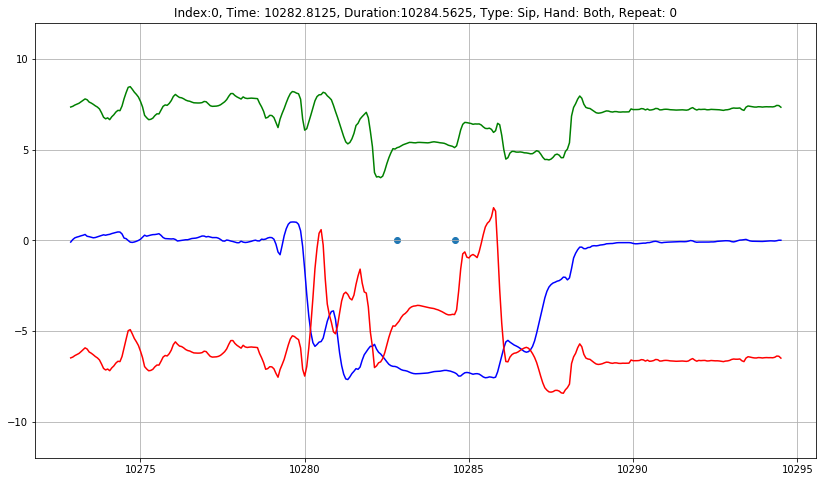

Index:1, Time: 11846.375, Duration:11847.875, Type: Sip, Hand: Both, Repeat: 0
11846.375 11847.875
343


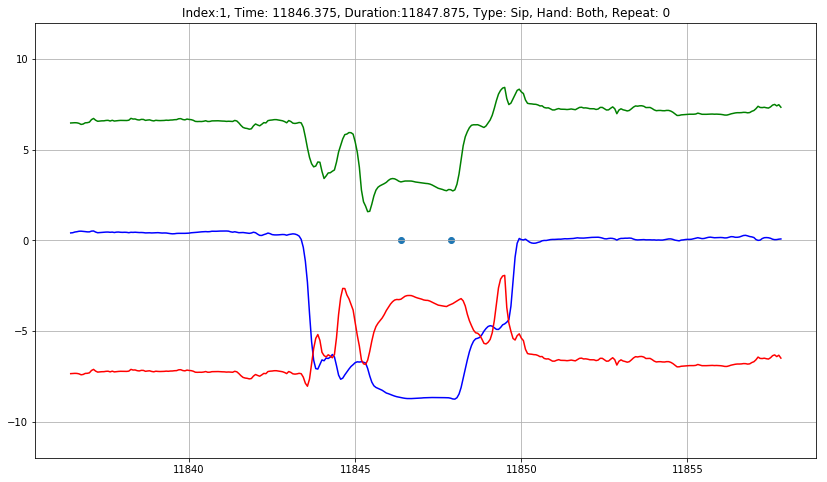

Index:2, Time: 12149.625, Duration:12151.125, Type: Sip, Hand: Both, Repeat: 0
12149.625 12151.125
343


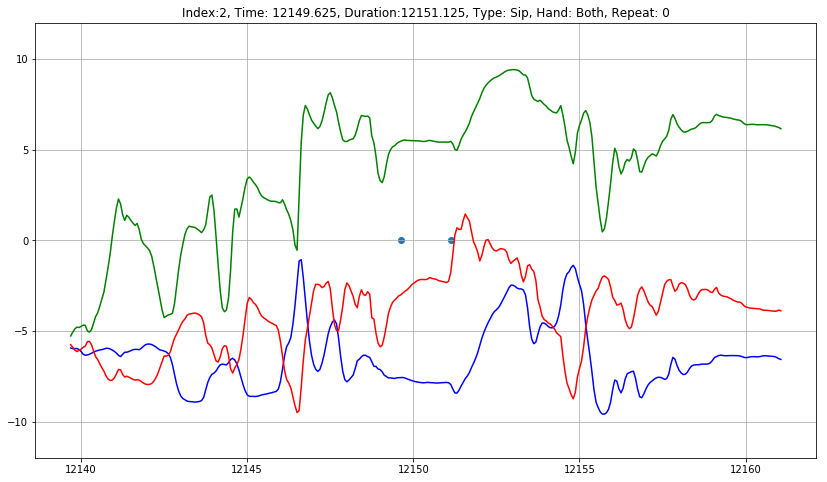

Index:3, Time: 18294.9375, Duration:18295.8125, Type: Sip, Hand: Both, Repeat: 0
18294.9375 18295.8125
333


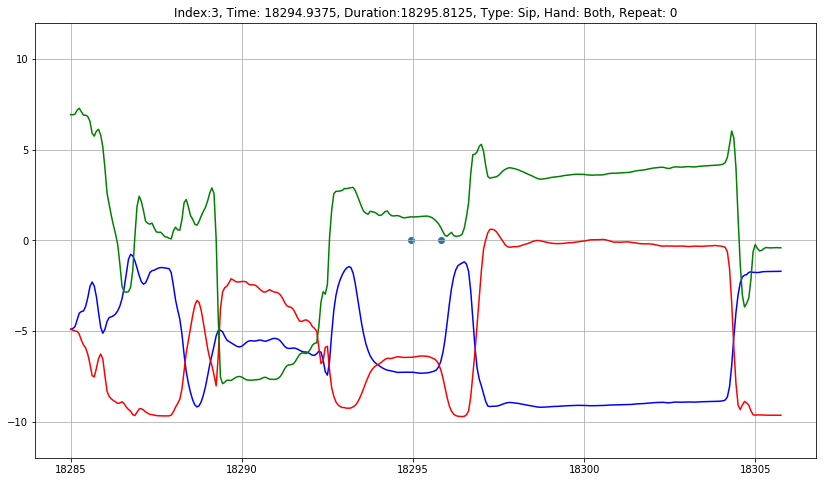

Index:4, Time: 19730.625, Duration:19731.625, Type: Sip, Hand: Left, Repeat: 0
19730.625 19731.625
335


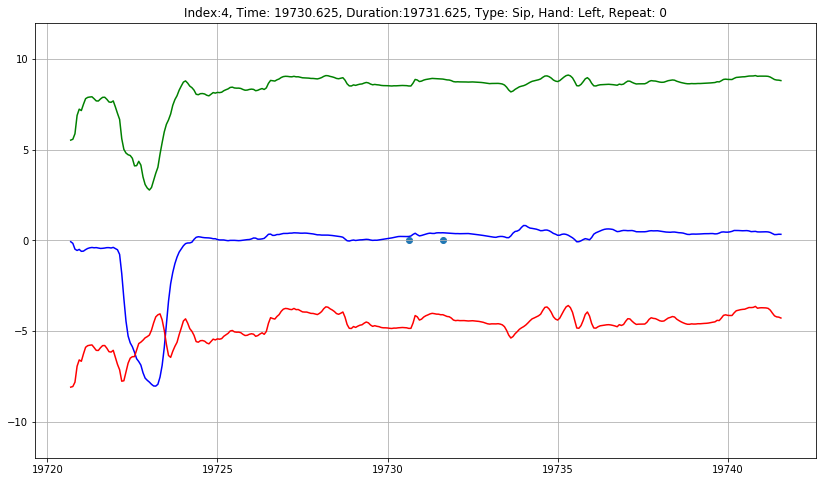

Index:5, Time: 19860.4375, Duration:19861.1875, Type: Sip, Hand: Left, Repeat: 0
19860.4375 19861.1875
331


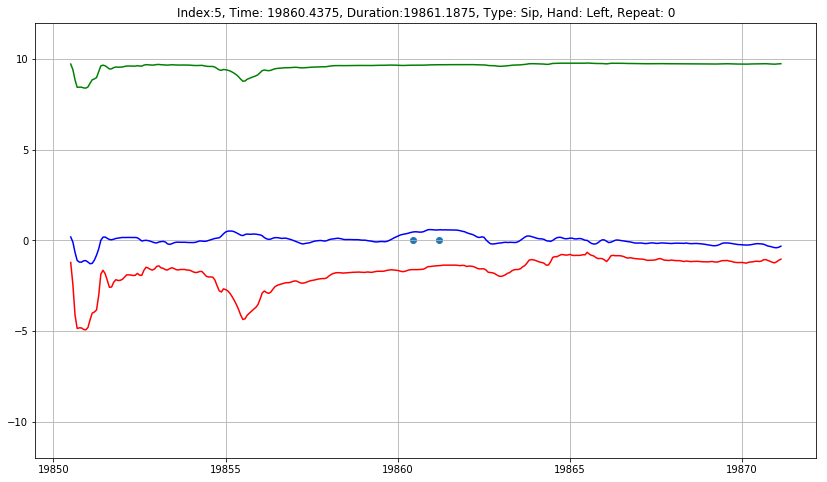

Index:6, Time: 20985.5625, Duration:20987.6875, Type: Sip, Hand: Left, Repeat: 0
20985.5625 20987.6875
353


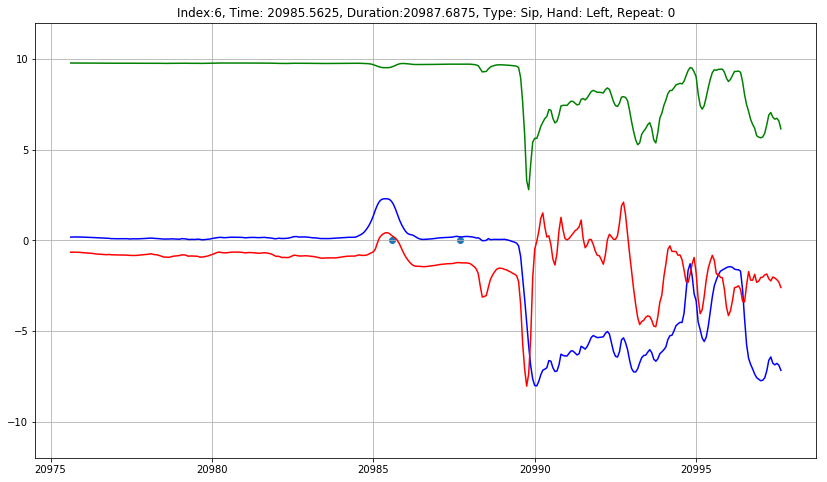

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_title(annots, current_index):
    a = annots[current_index]
    bs, hand = ["", "Bite", "Sip"], ["", "Right", "Left", "Both"]     
    return "Index:{}, Time: {}, Duration:{}, Type: {}, Hand: {}, Repeat: {}".format(current_index, a[0]/16, a[1]/16, bs[int(a[2])], hand[int(a[3])], int(a[4]))

subj, sess = 0, 0
dr = ds[subj][sess]['data_right']
dl = ds[subj][sess]['data_left']
annots = ds[subj][sess]['annots']
print(len(annots))
cond = (annots[:, 2]==2)  & (annots[:, 3]>=2)
annots = annots[cond]

for current_index in range(0, len(annots)):#, len(annots)):
    print(get_title(annots, current_index))
    
    fig,ax=plt.subplots(figsize=(14,8))
    st = annots[current_index, 0]/16
    et = annots[current_index, 1]/16
    
    print(st, et)
    cond = (dr[:,0]>st-10) & (dr[:,0]<et+10)
    t = dr[cond, 0]
    print(len(t))
    ax = dr[cond, 1:4]
    gx = dr[cond, -3:]*9.81
    #plt.plot(t, ax[:, 0], linestyle=':', color='blue')    
    #plt.plot(t, ax[:, 1], linestyle=':', color='red')    
    #plt.plot(t, ax[:, 2], linestyle=':', color='green')    
    plt.plot(t, gx[:,0], color='blue')
    plt.plot(t, gx[:,1], color='red')
    plt.plot(t, gx[:,2], color='green')

    cond = (dl[:,0]>st-10) & (dl[:,0]<et+10)
    t = dl[cond, 0]
    ax = dl[cond, 1]
    gx = dl[cond, -3:]*9.81
    #plt.plot(t, ax[:, 0], linestyle='-', color='blue')    
    #plt.plot(t, ax[:, 1], linestyle=':', color='red')    
    #plt.plot(t, ax[:, 2], linestyle=':', color='green')    
    #plt.plot(t, gx[:,0], linestyle=':', color='blue')
    #plt.plot(t, gx[:,1], linestyle=':', color='red')
    #plt.plot(t, gx[:,2], linestyle=':', color='green')
    
    
    
    plt.scatter([st, et], [0, 0])

    plt.ylim([-12, 12])
    plt.grid(True)
    plt.title(get_title(annots, current_index))
    plt.draw() #redraw

    current_index+=1

    #fig.canvas.mpl_connect('button_press_event',onclick)
    plt.show()
    